In [40]:
import pandas as pd
import numpy as np
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
import re

In [2]:
# Initialize NLTK components
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amito\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amito\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\amito\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# Load news headlines and stock data
news_df = pd.read_csv("india-news-headlines.csv")

In [4]:
news_df

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic
...,...,...,...
3876552,20230630,city.goa,10 PIs move HC over thwarted seniority
3876553,20230630,city.goa,Govt notifies award in memory of Parrikar for ...
3876554,20230630,city.goa,After youth's death; PWD installs crash barrie...
3876555,20230630,city.goa,Authorities not acting against CRZ violations


In [5]:
# Define functions for data cleaning and feature engineering
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    stop_words = set(stopwords.words('english'))
    words = text.split()
    cleaned_text = ' '.join([word for word in words if word not in stop_words])
    return cleaned_text

In [6]:
# Preprocess news headlines
news_df.drop("headline_category", axis=1, inplace=True)
news_df.drop_duplicates(inplace=True)
news_df['publish_date'] = pd.to_datetime(news_df['publish_date'], format='%Y%m%d')
news_df = news_df.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()
news_df["cleaned_headline"] = news_df["headline_text"].apply(clean_text)


In [7]:
news_df

,publish_date,headline_text,cleaned_headline
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,status quo disturbed ayodhya says vajpayeefiss...
1,2001-01-03,"Powerless north India gropes in the dark,Think...",powerless north india gropes darkthink laxman ...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,string pulled stephen hawking indiavajpayee gi...
3,2001-01-05,Light combat craft takes India into club class...,light combat craft takes india club classhawki...
4,2001-01-06,Light combat craft takes India into club class...,light combat craft takes india club classhawki...
...,...,...,...
8165,2023-06-26,"How can loneliness worsen your mental health?,...",loneliness worsen mental healthcan spot three ...
8166,2023-06-27,Daily Horoscope; June 27; 2023: Read your dail...,daily horoscope june 27 2023 read daily astrol...
8167,2023-06-28,What is the 'courting hut' wedding ritual in A...,courting hut wedding ritual africadaily horosc...
8168,2023-06-29,Daily Horoscope; June 29; 2023: Read your dail...,daily horoscope june 29 2023 read daily astrol...


In [8]:
# Perform sentiment analysis on news headlines
analyzer = SentimentIntensityAnalyzer()
news_df["sentiment"] = news_df["cleaned_headline"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
news_df["sentiment_pos"] = news_df["cleaned_headline"].apply(lambda x: analyzer.polarity_scores(x)["pos"])
news_df["sentiment_neu"] = news_df["cleaned_headline"].apply(lambda x: analyzer.polarity_scores(x)["neu"])
news_df["sentiment_neg"] = news_df["cleaned_headline"].apply(lambda x: analyzer.polarity_scores(x)["neg"])

In [9]:
news_df

,publish_date,headline_text,cleaned_headline,sentiment,sentiment_pos,sentiment_neu,sentiment_neg
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,status quo disturbed ayodhya says vajpayeefiss...,-0.8627,0.102,0.746,0.152
1,2001-01-03,"Powerless north India gropes in the dark,Think...",powerless north india gropes darkthink laxman ...,0.7184,0.128,0.774,0.098
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,string pulled stephen hawking indiavajpayee gi...,0.6369,0.099,0.807,0.094
3,2001-01-05,Light combat craft takes India into club class...,light combat craft takes india club classhawki...,0.9643,0.197,0.681,0.121
4,2001-01-06,Light combat craft takes India into club class...,light combat craft takes india club classhawki...,0.2732,0.176,0.682,0.141
...,...,...,...,...,...,...,...
8165,2023-06-26,"How can loneliness worsen your mental health?,...",loneliness worsen mental healthcan spot three ...,-0.9998,0.091,0.736,0.172
8166,2023-06-27,Daily Horoscope; June 27; 2023: Read your dail...,daily horoscope june 27 2023 read daily astrol...,-0.9999,0.078,0.754,0.168
8167,2023-06-28,What is the 'courting hut' wedding ritual in A...,courting hut wedding ritual africadaily horosc...,-0.9994,0.092,0.774,0.134
8168,2023-06-29,Daily Horoscope; June 29; 2023: Read your dail...,daily horoscope june 29 2023 read daily astrol...,-0.9996,0.084,0.784,0.132


In [10]:
# Save the processed DataFrame to a new CSV file
news_df.to_csv('refined_news_data.csv', index=False)

In [11]:
news_df = pd.read_csv('refined_news_data.csv')

In [12]:
news_df

,publish_date,headline_text,cleaned_headline,sentiment,sentiment_pos,sentiment_neu,sentiment_neg
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,status quo disturbed ayodhya says vajpayeefiss...,-0.8627,0.102,0.746,0.152
1,2001-01-03,"Powerless north India gropes in the dark,Think...",powerless north india gropes darkthink laxman ...,0.7184,0.128,0.774,0.098
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,string pulled stephen hawking indiavajpayee gi...,0.6369,0.099,0.807,0.094
3,2001-01-05,Light combat craft takes India into club class...,light combat craft takes india club classhawki...,0.9643,0.197,0.681,0.121
4,2001-01-06,Light combat craft takes India into club class...,light combat craft takes india club classhawki...,0.2732,0.176,0.682,0.141
...,...,...,...,...,...,...,...
8165,2023-06-26,"How can loneliness worsen your mental health?,...",loneliness worsen mental healthcan spot three ...,-0.9998,0.091,0.736,0.172
8166,2023-06-27,Daily Horoscope; June 27; 2023: Read your dail...,daily horoscope june 27 2023 read daily astrol...,-0.9999,0.078,0.754,0.168
8167,2023-06-28,What is the 'courting hut' wedding ritual in A...,courting hut wedding ritual africadaily horosc...,-0.9994,0.092,0.774,0.134
8168,2023-06-29,Daily Horoscope; June 29; 2023: Read your dail...,daily horoscope june 29 2023 read daily astrol...,-0.9996,0.084,0.784,0.132


In [13]:
stock_df = pd.read_csv("stock_data.csv")

In [14]:
stock_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,"May 6, 2024","74,196.68","74,359.69","73,786.29","73,895.54","73,895.54","11,200"
1,"May 3, 2024","75,017.82","75,095.18","73,467.73","73,878.15","73,878.15","15,600"
2,"May 2, 2024","74,391.73","74,812.43","74,360.69","74,611.11","74,611.11","18,400"
3,"Apr 30, 2024","74,800.89","75,111.39","74,346.40","74,482.78","74,482.78","8,400"
4,"Apr 29, 2024","73,982.75","74,721.15","73,922.34","74,671.28","74,671.28","9,900"
...,...,...,...,...,...,...,...
5744,"Jan 8, 2001","4,164.76","4,206.72","4,101.53","4,120.43","4,120.43",-
5745,"Jan 5, 2001","4,116.34","4,195.01","4,115.35","4,183.73","4,183.73",-
5746,"Jan 4, 2001","4,180.97","4,180.97","4,109.55","4,115.37","4,115.37",-
5747,"Jan 3, 2001","3,977.58","4,067.66","3,977.58","4,060.02","4,060.02",-


In [15]:
def calculate_rsi(series, window):
    delta = series.diff().dropna()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [16]:
def calculate_obv(df):
    obv = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    return obv

In [17]:
def calculate_technical_indicators(df):
    # Simple Moving Averages (SMA)
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    # Exponential Moving Averages (EMA)
    df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    # Moving Average Convergence Divergence (MACD)
    df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
    # Relative Strength Index (RSI)
    df['RSI'] = calculate_rsi(df['Close'], window=14)
    # On-Balance Volume (OBV)
    df['OBV'] = calculate_obv(df)
    return df

In [18]:
# Preprocess stock data
# Drop unnecessary columns
stock_df.drop(["Adj Close"], axis=1, inplace=True)

stock_df['Date'] = pd.to_datetime(stock_df['Date'], format="%b %d, %Y")
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
stock_df[numeric_columns] = stock_df[numeric_columns].replace('-', np.nan)
stock_df[numeric_columns] = stock_df[numeric_columns].replace(',', '', regex=True).astype(float)
stock_df["Volume"] = stock_df["Volume"].interpolate(method="linear")
# Feature engineering for stock data
stock_df = calculate_technical_indicators(stock_df.copy())


In [19]:
stock_df

,Date,Open,High,Low,Close,Volume,SMA_5,SMA_10,EMA_5,EMA_10,MACD,RSI,OBV
0,2024-05-06,74196.68,74359.69,73786.29,73895.54,11200.0,NaN,NaN,73895.540000,73895.540000,0.000000,NaN,0.0
1,2024-05-03,75017.82,75095.18,73467.73,73878.15,15600.0,NaN,NaN,73889.743333,73892.378182,-1.387236,0.000000,-15600.0
2,2024-05-02,74391.73,74812.43,74360.69,74611.11,18400.0,NaN,NaN,74130.198889,74023.056694,56.011450,97.682415,2800.0
3,2024-04-30,74800.89,75111.39,74346.40,74482.78,8400.0,NaN,NaN,74247.725926,74106.642750,90.106473,83.416033,-5600.0
4,2024-04-29,73982.75,74721.15,73922.34,74671.28,9900.0,74307.772,NaN,74388.910617,74209.304068,130.829280,86.345321,4300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5744,2001-01-08,4164.76,4206.72,4101.53,4120.43,21200.0,4071.418,4086.566,4094.193904,4114.321736,-36.871355,38.626943,-84138400.0
5745,2001-01-05,4116.34,4195.01,4115.35,4183.73,21200.0,4100.848,4085.493,4124.039269,4126.941421,-29.554290,34.397699,-84117200.0
5746,2001-01-04,4180.97,4180.97,4109.55,4115.37,21200.0,4118.496,4085.709,4121.149513,4124.837526,-28.937964,30.239134,-84138400.0
5747,2001-01-03,3977.58,4067.66,3977.58,4060.02,21200.0,4120.972,4083.370,4100.773009,4113.052521,-32.540696,28.854779,-84159600.0


In [20]:
# Save the processed DataFrame to a new CSV file
stock_df.to_csv('refined_stock_data.csv', index=False)

In [21]:
stock_df= pd.read_csv('refined_stock_data.csv')

In [22]:
stock_df

,Date,Open,High,Low,Close,Volume,SMA_5,SMA_10,EMA_5,EMA_10,MACD,RSI,OBV
0,2024-05-06,74196.68,74359.69,73786.29,73895.54,11200.0,NaN,NaN,73895.540000,73895.540000,0.000000,NaN,0.0
1,2024-05-03,75017.82,75095.18,73467.73,73878.15,15600.0,NaN,NaN,73889.743333,73892.378182,-1.387236,0.000000,-15600.0
2,2024-05-02,74391.73,74812.43,74360.69,74611.11,18400.0,NaN,NaN,74130.198889,74023.056694,56.011450,97.682415,2800.0
3,2024-04-30,74800.89,75111.39,74346.40,74482.78,8400.0,NaN,NaN,74247.725926,74106.642750,90.106473,83.416033,-5600.0
4,2024-04-29,73982.75,74721.15,73922.34,74671.28,9900.0,74307.772,NaN,74388.910617,74209.304068,130.829280,86.345321,4300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5744,2001-01-08,4164.76,4206.72,4101.53,4120.43,21200.0,4071.418,4086.566,4094.193904,4114.321736,-36.871355,38.626943,-84138400.0
5745,2001-01-05,4116.34,4195.01,4115.35,4183.73,21200.0,4100.848,4085.493,4124.039269,4126.941421,-29.554290,34.397699,-84117200.0
5746,2001-01-04,4180.97,4180.97,4109.55,4115.37,21200.0,4118.496,4085.709,4121.149513,4124.837526,-28.937964,30.239134,-84138400.0
5747,2001-01-03,3977.58,4067.66,3977.58,4060.02,21200.0,4120.972,4083.370,4100.773009,4113.052521,-32.540696,28.854779,-84159600.0


In [23]:
# Merge news and stock data using date as the key
news_df.rename(columns={"publish_date": "Date"}, inplace=True)
merged_df = pd.merge(news_df, stock_df, on="Date", how="inner")

In [24]:
merged_df

,Date,headline_text,cleaned_headline,sentiment,sentiment_pos,sentiment_neu,sentiment_neg,Open,High,Low,Close,Volume,SMA_5,SMA_10,EMA_5,EMA_10,MACD,RSI,OBV
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,status quo disturbed ayodhya says vajpayeefiss...,-0.8627,0.102,0.746,0.152,3953.22,4028.57,3929.37,4018.88,21200.0,4099.686,4078.185,4073.475339,4095.930245,-38.274338,28.270803,-84180800.0
1,2001-01-03,"Powerless north India gropes in the dark,Think...",powerless north india gropes darkthink laxman ...,0.7184,0.128,0.774,0.098,3977.58,4067.66,3977.58,4060.02,21200.0,4120.972,4083.370,4100.773009,4113.052521,-32.540696,28.854779,-84159600.0
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,string pulled stephen hawking indiavajpayee gi...,0.6369,0.099,0.807,0.094,4180.97,4180.97,4109.55,4115.37,21200.0,4118.496,4085.709,4121.149513,4124.837526,-28.937964,30.239134,-84138400.0
3,2001-01-05,Light combat craft takes India into club class...,light combat craft takes india club classhawki...,0.9643,0.197,0.681,0.121,4116.34,4195.01,4115.35,4183.73,21200.0,4100.848,4085.493,4124.039269,4126.941421,-29.554290,34.397699,-84117200.0
4,2001-01-08,"Sangh Parivar; Babri panel up the ante,Frontru...",sangh parivar babri panel antefrontrunner key ...,-0.9571,0.036,0.810,0.153,4164.76,4206.72,4101.53,4120.43,21200.0,4071.418,4086.566,4094.193904,4114.321736,-36.871355,38.626943,-84138400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5507,2023-06-23,Axis Bank appoints former RBI DG NS Vishwanath...,axis bank appoints former rbi dg ns vishwanath...,-0.9998,0.083,0.762,0.155,63124.28,63240.63,62874.12,62979.37,7300.0,63599.876,64519.561,63571.030532,64231.293092,-691.120785,16.682921,-1126850.0
5508,2023-06-26,"How can loneliness worsen your mental health?,...",loneliness worsen mental healthcan spot three ...,-0.9998,0.091,0.736,0.172,62946.50,63136.09,62853.67,62970.00,4400.0,64045.012,64756.041,63866.860798,64509.498223,-599.873082,14.815492,-1134150.0
5509,2023-06-27,Daily Horoscope; June 27; 2023: Read your dail...,daily horoscope june 27 2023 read daily astrol...,-0.9999,0.078,0.754,0.168,63151.85,63467.54,63054.84,63416.03,4800.0,64546.822,65020.825,64315.291197,64851.608939,-473.728369,15.543124,-1129750.0
5510,2023-06-28,What is the 'courting hut' wedding ritual in A...,courting hut wedding ritual africadaily horosc...,-0.9994,0.092,0.774,0.134,63701.78,64050.44,63554.82,63915.42,6300.0,64952.824,65218.612,64764.921795,65170.626481,-351.245214,16.194038,-1124950.0


In [25]:
# Drop unnecessary columns
merged_df.drop(["headline_text","cleaned_headline"], axis=1, inplace=True)

In [26]:
# Save the processed DataFrame to a new CSV file
merged_df.to_csv('refined_merged_data.csv', index=False)

In [27]:
merged_df

,Date,sentiment,sentiment_pos,sentiment_neu,sentiment_neg,Open,High,Low,Close,Volume,SMA_5,SMA_10,EMA_5,EMA_10,MACD,RSI,OBV
0,2001-01-02,-0.8627,0.102,0.746,0.152,3953.22,4028.57,3929.37,4018.88,21200.0,4099.686,4078.185,4073.475339,4095.930245,-38.274338,28.270803,-84180800.0
1,2001-01-03,0.7184,0.128,0.774,0.098,3977.58,4067.66,3977.58,4060.02,21200.0,4120.972,4083.370,4100.773009,4113.052521,-32.540696,28.854779,-84159600.0
2,2001-01-04,0.6369,0.099,0.807,0.094,4180.97,4180.97,4109.55,4115.37,21200.0,4118.496,4085.709,4121.149513,4124.837526,-28.937964,30.239134,-84138400.0
3,2001-01-05,0.9643,0.197,0.681,0.121,4116.34,4195.01,4115.35,4183.73,21200.0,4100.848,4085.493,4124.039269,4126.941421,-29.554290,34.397699,-84117200.0
4,2001-01-08,-0.9571,0.036,0.810,0.153,4164.76,4206.72,4101.53,4120.43,21200.0,4071.418,4086.566,4094.193904,4114.321736,-36.871355,38.626943,-84138400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5507,2023-06-23,-0.9998,0.083,0.762,0.155,63124.28,63240.63,62874.12,62979.37,7300.0,63599.876,64519.561,63571.030532,64231.293092,-691.120785,16.682921,-1126850.0
5508,2023-06-26,-0.9998,0.091,0.736,0.172,62946.50,63136.09,62853.67,62970.00,4400.0,64045.012,64756.041,63866.860798,64509.498223,-599.873082,14.815492,-1134150.0
5509,2023-06-27,-0.9999,0.078,0.754,0.168,63151.85,63467.54,63054.84,63416.03,4800.0,64546.822,65020.825,64315.291197,64851.608939,-473.728369,15.543124,-1129750.0
5510,2023-06-28,-0.9994,0.092,0.774,0.134,63701.78,64050.44,63554.82,63915.42,6300.0,64952.824,65218.612,64764.921795,65170.626481,-351.245214,16.194038,-1124950.0


In [28]:
def rolling_window_forecast(df, window_size):
    predictions = []
    actuals = []
    dates = []

    for i in range(len(df) - window_size):
        train_df = df[i:i + window_size]
        test_df = df[i + window_size:i + window_size + 1]
        
        # Prepare training data
        X_train = train_df.drop(['Date', 'Close'], axis=1)
        y_train = train_df['Close']
        
        # Prepare test data
        X_test = test_df.drop(['Date', 'Close'], axis=1)
        y_test = test_df['Close']
        dates.append(test_df['Date'].values[0])
        
        # Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train the model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        predictions.append(y_pred[0])
        actuals.append(y_test.values[0])
        
        # Debugging print statements
        print(f"Window {i+1}/{len(df) - window_size}")
        print(f"Train period: {train_df['Date'].values[0]} to {train_df['Date'].values[-1]}")
        print(f"Test date: {test_df['Date'].values[0]}")
        print(f"Prediction: {y_pred[0]}, Actual: {y_test.values[0]}")
    
    return predictions, actuals, dates


In [29]:
# Set window size for rolling window forecast
window_size = 30  # Adjust window size as needed

In [30]:
# Apply rolling window forecast
predictions, actuals, dates = rolling_window_forecast(merged_df, window_size)


Window 1/5482
Train period: 2001-01-02 to 2001-02-26
Test date: 2001-02-27
Prediction: 4100.7625, Actual: 4069.68
Window 2/5482
Train period: 2001-01-03 to 2001-02-27
Test date: 2001-02-28
Prediction: 4124.779099999999, Actual: 4247.04
Window 3/5482
Train period: 2001-01-04 to 2001-02-28
Test date: 2001-03-01
Prediction: 4202.603899999995, Actual: 4271.65
Window 4/5482
Train period: 2001-01-05 to 2001-03-01
Test date: 2001-03-02
Prediction: 4195.8436999999985, Actual: 4095.16
Window 5/5482
Train period: 2001-01-08 to 2001-03-02
Test date: 2001-03-05
Prediction: 4096.364199999998, Actual: 3998.12
Window 6/5482
Train period: 2001-01-09 to 2001-03-05
Test date: 2001-03-09
Prediction: 4064.7231999999967, Actual: 3881.96
Window 7/5482
Train period: 2001-01-10 to 2001-03-09
Test date: 2001-03-13
Prediction: 3943.183000000002, Actual: 3540.65
Window 8/5482
Train period: 2001-01-23 to 2001-03-13
Test date: 2001-03-14
Prediction: 3845.8711000000035, Actual: 3725.03
Window 9/5482
Train period: 2

In [31]:
# Evaluate the model's performance
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)

print(f"MAE: {mae}, RMSE: {rmse}, R-squared: {r2}")

MAE: 167.64977522801925, RMSE: 279.62931555334814, R-squared: 0.9996962140337836


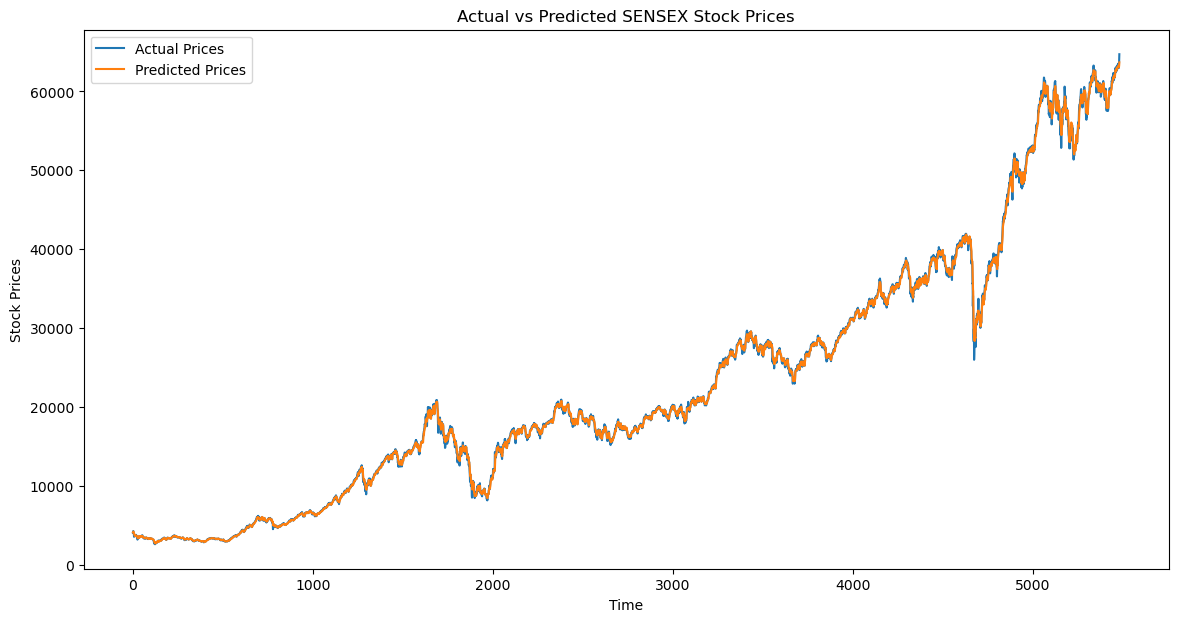

In [37]:
# Plotting the predicted vs actual stock prices
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.title('Actual vs Predicted SENSEX Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.legend()
plt.show()

# This project shows how we can use machine learning and natural language processing to predict stock prices. While our model performs well, there’s always room for improvement. Future work could involve using more advanced models, incorporating additional data sources, or experimenting with different feature engineering techniques.